In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import joblib
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/content/drive/MyDrive/D-CLIC/projet_energisight/data/df_processed_final.csv')
df.head()

,osebuildingid,datayear,buildingtype,primarypropertytype,propertyname,address,city,state,zipcode,taxparcelidentificationnumber,...,cat_Hospitality,cat_Other,cat_Public_Assembly,cat_Residential,cat_Storage,is_public_building,star_score_percentile,renovation_potential_index,surface_exposure_index,structural_complexity_score
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,True,False,False,False,False,0,0.255988,35.60,6802.615385,10.137121
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,True,False,False,False,False,0,0.271814,7.80,8630.500000,6.928784
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,True,False,False,False,False,0,0.148417,26.79,22764.523810,6.472196
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,True,False,False,False,False,0,0.221985,39.60,5574.545455,9.921490
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,True,False,False,False,False,0,0.578700,9.00,9241.052632,13.041924


In [3]:
# --- ÉTAPE FINALE : PRÉPARATION DU SET D'ENTRAÎNEMENT ---

# 1. Définition des cibles
target_emissions = 'totalghgemissions'
target_energy = 'siteenergyusekbtu'

# 2. Liste noire des variables à exclure (Fuites + Identifiants + Texte)
drop_cols = [
    # Cibles et dérivés
    'totalghgemissions', 'siteenergyusekbtu', 'siteenergyusewnkbtu',
    'siteeuiwnkbtu_sf', 'sourceeuikbtu_sf', 'sourceeuiwnkbtu_sf',
    'ghgemissionsintensity', 'electricitykwh', 'electricitykbtu',
    'naturalgaskbtu', 'naturalgastherms', 'steamusekbtu',

    # Identifiants et Metadata
    'osebuildingid', 'propertyname', 'address', 'city', 'state', 'zipcode',
    'taxparcelidentificationnumber', 'listofallpropertyusetypes',
    'primarypropertytype', 'neighborhood', 'compliancestatus',
    'building_age_category', 'construction_era', 'size_category',
    'building_macro_category', 'defaultdata'
]

# 3. Création du set de features X
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 4. Vérification des types
# On s'assure qu'il ne reste que du numérique (int, float, bool)
non_numeric = X.select_dtypes(exclude=[np.number, bool]).columns
if len(non_numeric) > 0:
    print(f" Attention, colonnes non-numériques restantes : {list(non_numeric)}")
else:
    print(f"Features prêtes : {X.shape[1]} variables conservées.")

 Attention, colonnes non-numériques restantes : ['buildingtype', 'largestpropertyusetype']


In [4]:
# Top 15 des variables les plus corrélées à la cible
print("Top 15 - Corrélation avec les émissions :")
print(df.corr(numeric_only=True)[target_emissions].sort_values(ascending=False).head(16)[1:])

Top 15 - Corrélation avec les émissions :
siteenergyusekbtu            0.861066
siteenergyusewnkbtu          0.857714
naturalgastherms             0.728917
naturalgaskbtu               0.728917
electricitykwh               0.687616
electricitykbtu              0.687616
steamusekbtu                 0.683762
largestpropertyusetypegfa    0.575851
propertygfabuildings         0.543529
size_vs_neighborhood         0.542319
propertygfatotal             0.528070
ghgemissionsintensity        0.471397
age_size_interaction         0.438399
surface_exposure_index       0.428584
numberofbuildings            0.414719
Name: totalghgemissions, dtype: float64


In [5]:
# 1. Sélection des colonnes par type
# On exclut les colonnes de texte brut et les cibles avant de définir les types
features_to_drop = [target_emissions, target_energy] + drop_cols
X_raw = df.drop(columns=[c for c in features_to_drop if c in df.columns])

numeric_features = X_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['buildingtype', 'largestpropertyusetype'] # Les deux récalcitrantes

# 2. Création des transformateurs
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Assemblage du ColumnTransformer (Le cerveau du pipeline)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Définition du Pipeline Global avec un modèle simple (Baseline)
# On utilise RandomForest car il est robuste et gère bien les non-linéarités
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])



In [6]:
# 5. Préparation des données (Split)
y = df[target_energy]
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# 6. Entraînement et Cross-Validation
print("Lancement de la Cross-Validation (5-folds)...")
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='r2')

print(f"R² moyen (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Fit final pour évaluation sur le test set
model_pipeline.fit(X_train, y_train)
test_score = model_pipeline.score(X_test, y_test)
print(f" R² sur le Test Set: {test_score:.4f}")

Lancement de la Cross-Validation (5-folds)...
R² moyen (CV): 0.5462 (+/- 0.1498)
 R² sur le Test Set: 0.7465


In [7]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

y_energy = df[target_energy]

# 2. On réutilise nos meilleurs paramètres XGBoost pour la cohérence
best_xgb_energy = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 3. Pipeline dédié à l'énergie
energy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=best_xgb_energy,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

# 4. Split et Entraînement
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_raw, y_energy, test_size=0.2, random_state=42)

print("⚡ Entraînement du modèle de prédiction énergétique...")
energy_pipeline.fit(X_train_e, y_train_e)

# 5. Évaluation
y_pred_e = energy_pipeline.predict(X_test_e)
r2_e = energy_pipeline.score(X_test_e, y_test_e)
mae_e = mean_absolute_error(y_test_e, y_pred_e)
mape_e = mean_absolute_percentage_error(y_test_e, y_pred_e)

print(f"R² Energy : {r2_e:.4f}")
print(f"MAE Energy : {mae_e:.2f} kBtu")
print(f"MAPE Energy : {mape_e:.2%}")

⚡ Entraînement du modèle de prédiction énergétique...
R² Energy : 0.8376
MAE Energy : 2190184.78 kBtu
MAPE Energy : 33.21%


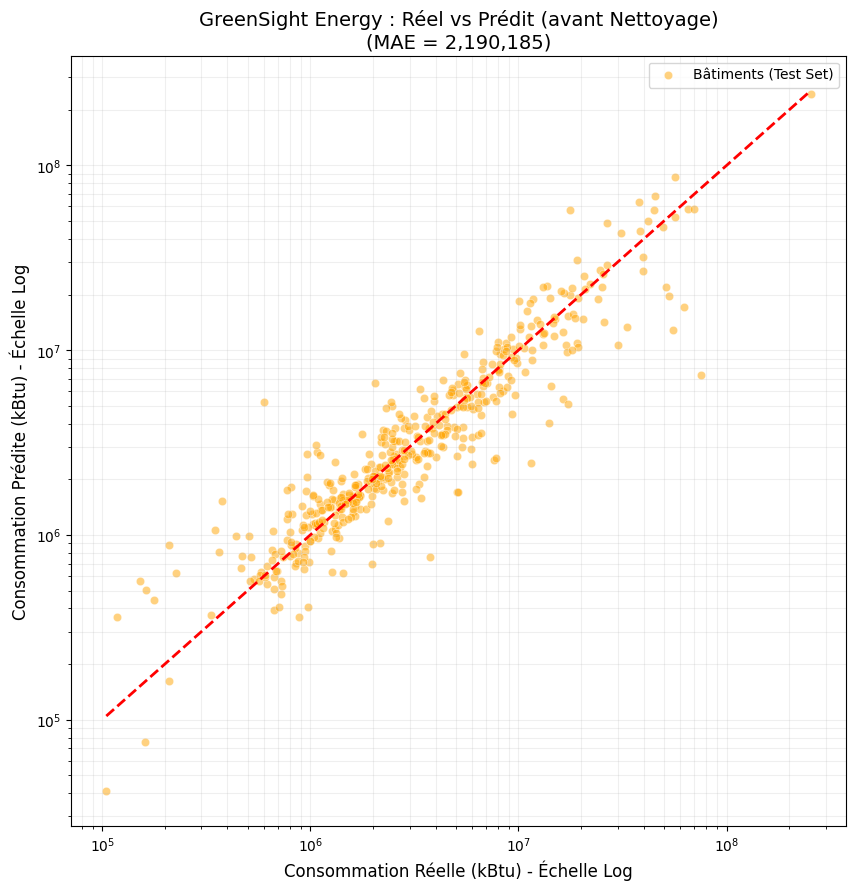

In [8]:
plt.figure(figsize=(10, 10))

# Tracé avec les nouvelles prédictions
sns.scatterplot(x=y_test_e, y=y_pred_e, alpha=0.5, color='orange', label='Bâtiments (Test Set)')

# Ligne de référence
line_coords = [y_test_e.min(), y_test_e.max()]
plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Prédiction Parfaite')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Consommation Réelle (kBtu) - Échelle Log', fontsize=12)
plt.ylabel('Consommation Prédite (kBtu) - Échelle Log', fontsize=12)
plt.title(f'GreenSight Energy : Réel vs Prédit (avant Nettoyage)\n(MAE = {mean_absolute_error(y_test_e, y_pred_e):,.0f})', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [9]:
# 2. Enregistrement du modèle Énergie (Le plus stable : 0.83)
# On l'appelle 'greensight_energy_model.pkl'
joblib.dump(energy_pipeline, 'greensight_energy_model.pkl')

['greensight_energy_model.pkl']

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error # Added r2_score

# 1. Mise à jour du Pipeline avec SelectKBest
energy_pipeline_kbest = Pipeline(steps=[
    ('preprocessor', preprocessor), # Ton préprocesseur actuel
    ('feature_selection', SelectKBest(score_func=f_regression, k=8)), # On garde le top 8
    ('regressor', TransformedTargetRegressor(
        regressor=xgb.XGBRegressor(
            n_estimators=800,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

# 2. Entraînement
print("⚡ Entraînement avec les 8 meilleures features...")
energy_pipeline_kbest.fit(X_train_e, y_train_e)

# 3. Évaluation
y_pred_k8 = energy_pipeline_kbest.predict(X_test_e)
r2_k8 = r2_score(y_test_e, y_pred_k8)
mae_k8 = mean_absolute_error(y_test_e, y_pred_k8)

print(f" [K=8] R² Energy : {r2_k8:.4f}")
print(f"[K=8] MAE Energy : {mae_k8:.2f} kBtu")

⚡ Entraînement avec les 8 meilleures features...
 [K=8] R² Energy : 0.2485
[K=8] MAE Energy : 4154034.42 kBtu
